# GroupBy机制
- DataFrame可以在其行（axis=0）或列（axis=1）上进行分组。然后，将一个函数应用（apply）到各个分
组并产生一个新值。最后，所有这些函数的执行结果会被合并（combine）到最终的
结果对象中。

- 分组键可以有多种形式，且类型不必相同：
- 列表或数组，其长度与待分组的轴一样。
- 表示DataFrame某个列名的值。
- 字典或Series，给出待分组轴上的值与分组名之间的对应关系。
- 函数，用于处理轴索引或索引中的各个标签。

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})
df

,data1,data2,key1,key2
0,-0.901580,-0.200000,a,one
1,-1.661253,0.602275,a,two
2,-2.286095,0.568984,b,one
3,-0.611613,-1.270324,b,two
4,0.326954,0.202554,a,one


In [3]:
grouped = df['data1'].groupby(df['key1'])
grouped

- 之前习惯用的办法

In [4]:
df.groupby(df['key1']).mean()['data1']

key1
a   -0.745293
b   -1.448854
Name: data1, dtype: float64

In [5]:
grouped.mean()
# 结果一样

key1
a   -0.745293
b   -1.448854
Name: data1, dtype: float64

- 这里最重要的是，数据（Series）根据分组键
进行了聚合，产生了一个新的Series，其索引为key1列中的唯一值

In [6]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one    -0.287313
      two    -1.661253
b     one    -2.286095
      two    -0.611613
Name: data1, dtype: float64

In [7]:
means.unstack()

key2,one,two
key1,,
a,-0.287313,-1.661253
b,-2.286095,-0.611613


In [10]:
print(df)
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean()

      data1     data2 key1 key2
0 -0.901580 -0.200000    a  one
1 -1.661253  0.602275    a  two
2 -2.286095  0.568984    b  one
3 -0.611613 -1.270324    b  two
4  0.326954  0.202554    a  one


California  2005   -1.661253
            2006   -2.286095
Ohio        2005   -0.756597
            2006    0.326954
Name: data1, dtype: float64

- 通常，分组信息就位于相同的要处理DataFrame中。这里，可以将列名（可以是
字符串、数字或其他Python对象）用作分组键

In [11]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,-0.745293,0.201609
b,-1.448854,-0.350670


执行df.groupby('key1').mean()时，结果中没有
key2列。这是因为df['key2']不是数值数据（俗称“麻烦列”），所以被从结果中排除
了。默认情况下，所有数值列都会被聚合，虽然有时可能会被过滤为一个子集

In [12]:
df.groupby(['key1','key2']).mean()

data1     data2
key1 key2                    
a    one  -0.287313  0.001277
     two  -1.661253  0.602275
b    one  -2.286095  0.568984
     two  -0.611613 -1.270324

In [19]:
df.groupby(['key1','key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

## 对分组进行迭代
- GroupBy对象支持迭代，可以产生一组二元元组（由分组名和数据块组成）。看下面
的例子

In [13]:
for name, group in df.groupby('key1'):
    print("name:",name)
    print('group:',group)

name: a
group:       data1     data2 key1 key2
0 -0.901580 -0.200000    a  one
1 -1.661253  0.602275    a  two
4  0.326954  0.202554    a  one
name: b
group:       data1     data2 key1 key2
2 -2.286095  0.568984    b  one
3 -0.611613 -1.270324    b  two


- 对于多重键的情况，元组的第一个元素将会是由键值组成的元组

In [17]:
for i, (name, group) in enumerate(df.groupby('key2')):
    print(i)
    print("name{}:".format(i),name)
    print('group{}:'.format(i),group)

0
name0: one
group0:       data1     data2 key1 key2
0 -0.901580 -0.200000    a  one
2 -2.286095  0.568984    b  one
4  0.326954  0.202554    a  one
1
name1: two
group1:       data1     data2 key1 key2
1 -1.661253  0.602275    a  two
3 -0.611613 -1.270324    b  two


In [18]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
      data1     data2 key1 key2
0 -0.901580 -0.200000    a  one
4  0.326954  0.202554    a  one
('a', 'two')
      data1     data2 key1 key2
1 -1.661253  0.602275    a  two
('b', 'one')
      data1     data2 key1 key2
2 -2.286095  0.568984    b  one
('b', 'two')
      data1     data2 key1 key2
3 -0.611613 -1.270324    b  two


- 可以对这些数据片段做任何操作。有一个你可能会觉得有用的运算：将这些
数据片段做成一个字典

In [20]:
pieces = dict(list(df.groupby('key1')))
pieces

{'a':       data1     data2 key1 key2
 0 -0.901580 -0.200000    a  one
 1 -1.661253  0.602275    a  two
 4  0.326954  0.202554    a  one, 'b':       data1     data2 key1 key2
 2 -2.286095  0.568984    b  one
 3 -0.611613 -1.270324    b  two}

In [23]:
pieces['b']

,data1,data2,key1,key2
2,-2.286095,0.568984,b,one
3,-0.611613,-1.270324,b,two


In [26]:
pieces.get('b')

,data1,data2,key1,key2
2,-2.286095,0.568984,b,one
3,-0.611613,-1.270324,b,two


- groupby默认是在axis=0上进行分组的，通过设置也可以在其他任何轴上进行分组。
拿上面例子中的df来说，我们可以根据dtype对列进行分组

In [28]:
df.dtypes

data1    float64
data2    float64
key1      object
key2      object
dtype: object

In [29]:
grouped = df.groupby(df.dtypes,axis=1)

In [30]:
for dtype, group in grouped:
    print(dtype)
    print(group)

float64
      data1     data2
0 -0.901580 -0.200000
1 -1.661253  0.602275
2 -2.286095  0.568984
3 -0.611613 -1.270324
4  0.326954  0.202554
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


## 选取一列或列的子集
- 对于由DataFrame产生的GroupBy对象，如果用一个（单个字符串）或一组（字符串
数组）列名对其进行索引，就能实现选取部分列进行聚合的目的。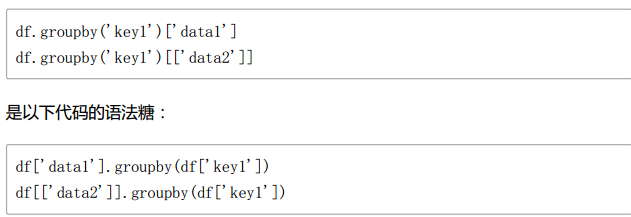

In [31]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one   0.001277
     two   0.602275
b    one   0.568984
     two  -1.270324

In [37]:
type(df.groupby(['key1', 'key2']).mean()['data2'])

pandas.core.series.Series

In [38]:
%timeit
type(df.groupby(['key1', 'key2']).mean()[['data2']])

pandas.core.frame.DataFrame

## 通过字典或Series进行分组
除数组以外，分组信息还可以其他形式存在

In [41]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
# people.iloc[2:3,[1,2]] = np.nan
people.iloc[2,[1,2]] = np.nan
people

,a,b,c,d,e
Joe,0.022869,-0.394367,-0.477653,1.522804,-0.519711
Steve,-0.216665,0.264974,-0.637254,-0.471684,-0.555005
Wes,1.094060,NaN,NaN,0.319676,-0.220151
Jim,0.193404,-0.107262,1.190674,0.716094,-0.561097
Travis,-0.639913,-0.710605,0.534521,-0.817216,0.853414


- 假设已知列的分组关系，并希望根据分组计算列的和

In [42]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f' : 'orange'}

- 现在，你可以将这个字典传给groupby，来构造数组，但我们可以直接传递字典（
- 包含了键“f”来强调，存在未使用的分组键是可以的）

In [43]:
by_column = people.groupby(mapping, axis=1)
by_column.sum()

,blue,red
Joe,1.045151,-0.891210
Steve,-1.108938,-0.506697
Wes,0.319676,0.873909
Jim,1.906768,-0.474956
Travis,-0.282695,-0.497104


- Series也有同样的功能，它可以被看做一个固定大小的映射

In [44]:
map_series = pd.Series(mapping)
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [46]:
people.groupby(map_series, axis=1).sum()

,blue,red
Joe,1.045151,-0.891210
Steve,-1.108938,-0.506697
Wes,0.319676,0.873909
Jim,1.906768,-0.474956
Travis,-0.282695,-0.497104


## 通过函数进行分组 
比起使用字典或Series，使用Python函数是一种更原生的方法定
义分组映射。任何被当做分组键的函数都会在各个索引值上被调用一次，其返回值就
会被用作分组名称。

In [47]:
people.groupby(len).sum()

,a,b,c,d,e
3,1.310333,-0.501630,0.713021,2.558575,-1.300960
5,-0.216665,0.264974,-0.637254,-0.471684,-0.555005
6,-0.639913,-0.710605,0.534521,-0.817216,0.853414


- 将函数跟数组、列表、字典、Series混合使用也不是问题，
- 因为任何东西在内部都会被
转换为数组

In [48]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one  0.022869 -0.394367 -0.477653  0.319676 -0.519711
  two  0.193404 -0.107262  1.190674  0.716094 -0.561097
5 one -0.216665  0.264974 -0.637254 -0.471684 -0.555005
6 two -0.639913 -0.710605  0.534521 -0.817216  0.853414

## 根据索引级别分组
- 层次化索引数据集最方便的地方就在于它能够根据轴索引的一个级别进行聚合

In [56]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                     [1, 3, 5, 1, 3]],names=['cty', 'tenor'])
# columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
#                                     [1, 3, 5, 1, 3]],
#                                     names=['cty', 'tenor'])
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.541681  1.215717 -0.744331 -1.132354 -1.638047
1      0.725961  0.253581  0.035168 -0.294273 -0.608979
2      0.913409  0.595214 -0.317049 -0.200305 -0.768199
3      0.924079 -0.139913  0.590327 -0.387558 -0.299898

In [57]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


# 10.2 数据聚合
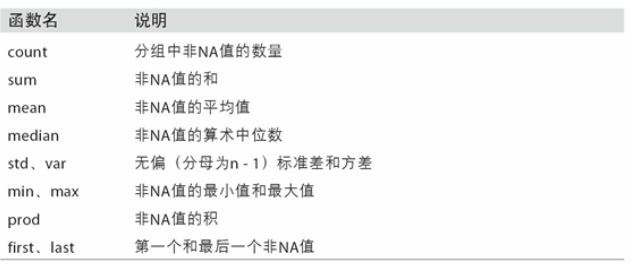

你可以使用自己发明的聚合运算，还可以调用分组对象上已经定义好的任何方法。例
如，quantile可以计算Series或DataFrame列的样本分位数。
- 虽然quantile并没有明确地实现于GroupBy，但它是一个Series方法，所以这里是能用
的。
- 实际上，GroupBy会高效地对Series进行切片，然后对各片调用
piece.quantile(0.9)，最后将这些结果组装成最终结果

In [58]:
df

,data1,data2,key1,key2
0,-0.901580,-0.200000,a,one
1,-1.661253,0.602275,a,two
2,-2.286095,0.568984,b,one
3,-0.611613,-1.270324,b,two
4,0.326954,0.202554,a,one


In [59]:
grouped = df.groupby('key1')
grouped['data1'].quantile(0.9)

key1
a    0.081247
b   -0.779061
Name: data1, dtype: float64

- 如果要使用你自己的聚合函数，只需将其传入aggregate或agg方法即可

In [61]:
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,1.988207,0.802275
b,1.674482,1.839307


- describe方法

In [60]:
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0 -0.745293  1.003275 -1.661253 -1.281417 -0.901580 -0.287313   
b      2.0 -1.448854  1.184038 -2.286095 -1.867475 -1.448854 -1.030234   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a     0.326954   3.0  0.201609  0.401138 -0.200000  0.001277  0.202554   
b    -0.611613   2.0 -0.350670  1.300587 -1.270324 -0.810497 -0.350670   

                          
           75%       max  
key1                      
a     0.402414  0.602275  
b     0.109157  0.568984

### 笔记：自定义聚合函数要比表10-1中那些经过优化的函数慢得多。这是因为在构造中间分组数据块时存在非常大的开销（函数调用、数据重排等）。

## 面向列的多函数应用

In [62]:
tips = pd.read_csv('examples/tips.csv')
# Add tip percentage of total bill
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips[:6]

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
5,25.29,4.71,No,Sun,Dinner,4,0.186240


- 你可能希望对不同的列使用不同的聚合函数，或一次应用多个函数。通过一些示例来进行讲解。
首先，根据天和smoker对tips进行分组

In [66]:
grouped = tips.groupby(['day', 'smoker'])
grouped_pct = grouped[["tip_pct"]]
grouped_pct.agg(['mean','std',peak_to_peak])

tip_pct                       
                 mean       std peak_to_peak
day  smoker                                 
Fri  No      0.151650  0.028123     0.067349
     Yes     0.174783  0.051293     0.159925
Sat  No      0.158048  0.039767     0.235193
     Yes     0.147906  0.061375     0.290095
Sun  No      0.160113  0.042347     0.193226
     Yes     0.187250  0.154134     0.644685
Thur No      0.160298  0.038774     0.193350
     Yes     0.163863  0.039389     0.151240

- 这里，我们传递了一组聚合函数进行聚合，独立对数据分组进行评估。
- 你并非一定要接受GroupBy自动给出的那些列名，特别是lambda函数，它们的名称
是''，这样的辨识度就很低了（通过函数的__name__属性看看就知道了）。
- 因此，如果传入的是一个由(name,function)元组组成的列表，则各元组的第一个元素就会被用
作DataFrame的列名（可以将这种二元元组列表看做一个有序映射）

In [68]:
grouped_pct.agg([('foo', 'mean'),('bar',np.std)])

tip_pct          
                  foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

In [71]:
grouped_pct.agg([('foo',np.mean),('bar','std')])

tip_pct          
                  foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

- 对于DataFrame，你还有更多选择，你可以定义一组应用于全部列的一组函数，或不
同的列应用不同的函数。假设我们想要对tip_pct和total_bill列计算三个统计信息

In [72]:
functions = ['count', 'mean', 'max']
result = grouped['tip_pct', 'total_bill'].agg(functions)
result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

- 结果DataFrame拥有层次化的列，这相当于分别对各列进行聚合，然后用
concat将结果组装到一起，使用列名用作keys参数

In [73]:
result['tip_pct']

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

- 方法传入自定义的一组元祖

In [74]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]
grouped['tip_pct', 'total_bill'].agg(ftuples)

tip_pct              total_bill            
            Durchschnitt Abweichung Durchschnitt  Abweichung
day  smoker                                                 
Fri  No         0.151650   0.000791    18.420000   25.596333
     Yes        0.174783   0.002631    16.813333   82.562438
Sat  No         0.158048   0.001581    19.661778   79.908965
     Yes        0.147906   0.003767    21.276667  101.387535
Sun  No         0.160113   0.001793    20.506667   66.099980
     Yes        0.187250   0.023757    24.120000  109.046044
Thur No         0.160298   0.001503    17.113111   59.625081
     Yes        0.163863   0.001551    19.190588   69.808518

- 现在，假设你想要对一个列或不同的列应用不同的函数。具体的办法是向agg传入一个
从列名映射到函数的字典

In [75]:
grouped.agg({'tip':np.max,'size':'sum'})

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [76]:
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'],
             'size' : 'sum'})

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

## 以“没有行索引”的形式返回聚合数据

In [77]:
tips.groupby(['day', 'smoker'], as_index=False).mean()
# 同reset_index

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


# 10.3 apply：一般性的“拆分－应用－合并”

- 根据分组选出最高的5个tip_pct值

In [79]:
# 自写一个top5函数
def top(df, n=5, column = 'tip_pct'):
    return df.sort_values(by=column)[-n:]

In [80]:
top(tips,n=6)

,total_bill,tip,smoker,day,time,size,tip_pct
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


In [81]:
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

- 原理：top函数在DataFrame的各个片段上调用，然后结果由pandas.concat组装到一起，并以分组名称进行了标记。于是，最终结果就有了一个层次化索引，其内层索引值来自原DataFrame。
- 如果传给apply的函数能够接受其他参数或关键字，则可以将这些内容放在函数名后面
一并传入

In [82]:
#  top函数传参
tips.groupby(['day','smoker']).apply(top, n=2, column='total_bill')

total_bill    tip smoker   day    time  size   tip_pct
day  smoker                                                            
Fri  No     91        22.49   3.50     No   Fri  Dinner     2  0.155625
            94        22.75   3.25     No   Fri  Dinner     2  0.142857
     Yes    90        28.97   3.00    Yes   Fri  Dinner     2  0.103555
            95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
Sat  No     59        48.27   6.73     No   Sat  Dinner     4  0.139424
            212       48.33   9.00     No   Sat  Dinner     4  0.186220
     Yes    102       44.30   2.50    Yes   Sat  Dinner     3  0.056433
            170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
Sun  No     112       38.07   4.00     No   Sun  Dinner     3  0.105070
            156       48.17   5.00     No   Sun  Dinner     6  0.103799
     Yes    184       40.55   3.00    Yes   Sun  Dinner     2  0.073983
            182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
Thur No     85        34.83   5.17     No  Thur   Lunch     4  0.148435
            142       41.19   5.00     No  Thur   Lunch     5  0.121389
     Yes    83        32.68   5.00    Yes  Thur   Lunch     2  0.152999
            197       43.11   5.00    Yes  Thur   Lunch     4  0.115982

## 禁止分组键
- 从上面的例子中可以看出，分组键会跟原始对象的索引共同构成结果对象中的层次化
索引。将group_keys=False传入groupby即可禁止该效果

In [83]:
tips.groupby('smoker', group_keys=False).apply(top)

,total_bill,tip,smoker,day,time,size,tip_pct
88,24.71,5.85,No,Thur,Lunch,2,0.236746
185,20.69,5.00,No,Sun,Dinner,5,0.241663
51,10.29,2.60,No,Sun,Dinner,2,0.252672
149,7.51,2.00,No,Thur,Lunch,2,0.266312
232,11.61,3.39,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


In [84]:
tips.groupby('smoker', ).apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

### 分位数和桶分析
- 第8章中讲过，pandas有一些能根据指定面元或样本分位数将数据拆分成多块
的工具（比如cut和qcut）。
- 将这些函数跟groupby结合起来，就能非常轻松地实现对数据集的桶（bucket）或分位数（quantile）分析了。
- 以下面这个简单的随机数据集为例，我们利用cut将其装入长度相等的桶中

In [86]:
frame = pd.DataFrame({'data1':np.random.randn(1000),
                     'data2':np.random.randn(1000)})
frame.head()

,data1,data2
0,0.441537,0.188030
1,0.264692,0.164231
2,-0.379296,0.675095
3,-0.300074,1.433665
4,0.835079,0.269526


In [91]:
quartiles = pd.cut(frame.data1, 4)
quartiles[:9]

0     (0.0837, 1.959]
1     (0.0837, 1.959]
2    (-1.791, 0.0837]
3    (-1.791, 0.0837]
4     (0.0837, 1.959]
5    (-3.674, -1.791]
6     (0.0837, 1.959]
7     (0.0837, 1.959]
8     (0.0837, 1.959]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-3.674, -1.791] < (-1.791, 0.0837] < (0.0837, 1.959] < (1.959, 3.834]]

- 由cut返回的Categorical对象可直接传递到groupby。因此，我们可以像下面这样对
data2列做一些统计计算

In [92]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
grouped = frame.data2.groupby(quartiles)

In [93]:
grouped.apply(get_stats)

data1                  
(-3.674, -1.791]  count     33.000000
                  max        1.741500
                  mean       0.039313
                  min       -1.531425
(-1.791, 0.0837]  count    456.000000
                  max        3.202253
                  mean       0.017815
                  min       -2.907221
(0.0837, 1.959]   count    485.000000
                  max        3.143680
                  mean      -0.002398
                  min       -3.232317
(1.959, 3.834]    count     26.000000
                  max        1.576324
                  mean       0.061385
                  min       -1.577911
Name: data2, dtype: float64

In [94]:
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-3.674, -1.791]",33.0,1.741500,0.039313,-1.531425
"(-1.791, 0.0837]",456.0,3.202253,0.017815,-2.907221
"(0.0837, 1.959]",485.0,3.143680,-0.002398,-3.232317
"(1.959, 3.834]",26.0,1.576324,0.061385,-1.577911


In [95]:
# Return quantile numbers
grouping = pd.qcut(frame.data1, 10, labels=False)
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,100.0,2.141971,-0.002292,-2.361589
1,100.0,2.150157,-0.054625,-2.676286
2,100.0,2.567756,0.135381,-1.884484
3,100.0,3.202253,0.069648,-2.907221
4,100.0,2.513465,-0.043376,-2.502201
5,100.0,2.971263,0.075007,-2.725782
6,100.0,2.889817,-0.051248,-2.766527
7,100.0,3.143680,0.032864,-2.815054
8,100.0,3.141332,-0.049888,-2.626529


In [96]:
grouping = pd.qcut(frame.data1, 10,)
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-3.667, -1.253]",100.0,2.141971,-0.002292,-2.361589
"(-1.253, -0.772]",100.0,2.150157,-0.054625,-2.676286
"(-0.772, -0.461]",100.0,2.567756,0.135381,-1.884484
"(-0.461, -0.167]",100.0,3.202253,0.069648,-2.907221
"(-0.167, 0.112]",100.0,2.513465,-0.043376,-2.502201
"(0.112, 0.328]",100.0,2.971263,0.075007,-2.725782
"(0.328, 0.6]",100.0,2.889817,-0.051248,-2.766527
"(0.6, 0.882]",100.0,3.143680,0.032864,-2.815054
"(0.882, 1.367]",100.0,3.141332,-0.049888,-2.626529


### 示例：用特定于分组的值填充缺失值

In [97]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
          'Oregon', 'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4

In [98]:
data = pd.Series(np.random.randn(8), index=states)
data

Ohio         -2.255000
New York     -0.287269
Vermont      -1.580519
Florida       0.803894
Oregon       -0.182536
Nevada       -0.928419
California   -0.237675
Idaho        -1.027785
dtype: float64

In [99]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data

Ohio         -2.255000
New York     -0.287269
Vermont            NaN
Florida       0.803894
Oregon       -0.182536
Nevada             NaN
California   -0.237675
Idaho              NaN
dtype: float64

- 缺失值用平均值填充

In [100]:
fill_mean = lambda x:x.fillna(x.mean())
data.groupby(group_key).apply(fill_mean)

Ohio         -2.255000
New York     -0.287269
Vermont      -0.579458
Florida       0.803894
Oregon       -0.182536
Nevada       -0.210106
California   -0.237675
Idaho        -0.210106
dtype: float64

- 也可以在代码中预定义各组的填充值。由于分组具有一个name属性，所以我们
可以拿来用一下

In [101]:
fill_values = {'East': 0.5, 'West': -1}
fill_foo = lambda x:x.fillna(fill_values[x.name])
data.groupby(group_key).apply(fill_foo)

Ohio         -2.255000
New York     -0.287269
Vermont       0.500000
Florida       0.803894
Oregon       -0.182536
Nevada       -1.000000
California   -0.237675
Idaho        -1.000000
dtype: float64

### 示例：随机采样和排列

In [1]:
# Hearts, Spades, Clubs, Diamonds
import pandas as pd
import numpy as np

suits = ['H', 'S', 'C', 'D']
card_val = (list(range(1, 11)) + [10] * 3) * 4
base_names = ['A'] + list(range(2, 11)) + ['J', 'K', 'Q']
print(base_names)


['A', 2, 3, 4, 5, 6, 7, 8, 9, 10, 'J', 'K', 'Q']


In [2]:
# 生成52副牌面
cards = [suit+str(num) for suit in suits for num in base_names]
len(cards)

52

In [3]:
deck = pd.Series(card_val,index=cards)
deck

HA      1
H2      2
H3      3
H4      4
H5      5
H6      6
H7      7
H8      8
H9      9
H10    10
HJ     10
HK     10
HQ     10
SA      1
S2      2
S3      3
S4      4
S5      5
S6      6
S7      7
S8      8
S9      9
S10    10
SJ     10
SK     10
SQ     10
CA      1
C2      2
C3      3
C4      4
C5      5
C6      6
C7      7
C8      8
C9      9
C10    10
CJ     10
CK     10
CQ     10
DA      1
D2      2
D3      3
D4      4
D5      5
D6      6
D7      7
D8      8
D9      9
D10    10
DJ     10
DK     10
DQ     10
dtype: int64

In [7]:
# 洗牌？，并抽中n张牌。
from sklearn.utils import shuffle 

def draw(deck, n=5):
    deck = shuffle(deck)
    return deck.sample(n)
draw(deck)

S2     2
DQ    10
DA     1
H4     4
CQ    10
dtype: int64

In [9]:
# 从每种花色中抽取两张牌
get_suit = lambda card:card[0]
deck.groupby(get_suit).apply(draw,n=2)

C  C6      6
   C7      7
D  D8      8
   DA      1
H  H2      2
   H10    10
S  S3      3
   S7      7
dtype: int64

In [10]:
# 取消层级化索引效果
deck.groupby(get_suit,group_keys=False).apply(draw,n=2)

CK    10
C3     3
D8     8
D5     5
H6     6
H2     2
SJ    10
S6     6
dtype: int64

## 示例：分组加权平均数和相关系数
- 根据groupby的“拆分－应用－合并”范式，可以进行DataFrame的列与列之间或两
个Series之间的运算（比如分组加权平均）。
- 以下面这个数据集为例，它含有分组键、
值以及一些权重值

In [11]:
df = pd.DataFrame({'category': ['a', 'a', 'a', 'a',
                                'b', 'b', 'b', 'b'],
                   'data': np.random.randn(8),
                   'weights': np.random.rand(8)})
df

,category,data,weights
0,a,-0.005394,0.449897
1,a,1.786038,0.877322
2,a,0.732834,0.499843
3,a,0.626139,0.724782
4,b,-1.399954,0.078931
5,b,-2.337960,0.441665
6,b,0.304829,0.110647
7,b,0.138401,0.719215


- 用category计算分组加权平均数

In [16]:
grouped = df.groupby('category')
for name, group in grouped:
    print(name)
    print(group)
# np.average(g['data'])
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])
grouped.apply(get_wavg)

a
  category      data   weights
0        a -0.005394  0.449897
1        a  1.786038  0.877322
2        a  0.732834  0.499843
3        a  0.626139  0.724782
b
  category      data   weights
4        b -1.399954  0.078931
5        b -2.337960  0.441665
6        b  0.304829  0.110647
7        b  0.138401  0.719215


category
a    0.934469
b   -0.747766
dtype: float64

### 任务：计算一个由日收益率（通过百分数变化计算）与SPX之间的年度相关系数组成的DataFrame。

In [17]:
close_px = pd.read_csv('examples/stock_px_2.csv', parse_dates=True,
                       index_col=0)
close_px.info()
close_px[-4:]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
AAPL    2214 non-null float64
MSFT    2214 non-null float64
XOM     2214 non-null float64
SPX     2214 non-null float64
dtypes: float64(4)
memory usage: 86.5 KB


,AAPL,MSFT,XOM,SPX
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


- 下面是一个实现办法，我们先创建一个函数，用它
计算每列和SPX列的成对相关系数

In [21]:
spx_corr = lambda x:x.corrwith(x['SPX'])

- DatFrames和Panel都有pct_change()函数。此函数将每个元素与其前一个元素进行比较，并计算变化百分比

In [19]:
rets = close_px.pct_change().dropna()

- 用年对百分比变化进行分组，可以用一个一行的函数，从每行的标签返回
每个datetime标签的year属性

In [23]:
get_year = lambda x:x.year
by_year = rets.groupby(get_year)
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


- 还可以计算列与列之间的相关系数。这里，我们计算Apple和Microsoft的年
相关系数

In [29]:
by_year.apply(lambda x:x['AAPL'].corr(x['MSFT']))
# by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

corr与corrwith。前者是两个series同级别相关；后者是df相关一列

## 示例：组级别的线性回归
顺着上一个例子继续，你可以用groupby执行更为复杂的分组统计分析，只要函数返
回的是pandas对象或标量值即可。例如，我可以定义下面这个regress函数（利用
statsmodels计量经济学库）对各数据块执行普通最小二乘法（Ordinary Least
Squares，OLS）回归：

In [41]:
# import statsmodels.api as sm
import statsmodels.api as sm
import statsmodels.api as sm
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1
    result = sm.OLS(Y, X).fit()
    return result.params

In [42]:
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


# 10.4 透视表和交叉表

- DataFrame有一个pivot_table方法，此外还有一个顶级的pandas.pivot_table函数。除能为groupby提供便利之外，
- pivot_table还可以添加分项小计，也叫做margins。
- 回到小费数据集，假设我想要根据day和smoker计算分组平均数（pivot_table的默认
聚合类型），并将day和smoker放到行上

In [43]:
tips = pd.read_csv('examples/tips.csv')
# Add tip percentage of total bill
tips['tip_pct'] = tips['tip'] / tips['total_bill']

In [45]:
tips.pivot_table(index=['day','smoker'])

size       tip   tip_pct  total_bill
day  smoker                                          
Fri  No      2.250000  2.812500  0.151650   18.420000
     Yes     2.066667  2.714000  0.174783   16.813333
Sat  No      2.555556  3.102889  0.158048   19.661778
     Yes     2.476190  2.875476  0.147906   21.276667
Sun  No      2.929825  3.167895  0.160113   20.506667
     Yes     2.578947  3.516842  0.187250   24.120000
Thur No      2.488889  2.673778  0.160298   17.113111
     Yes     2.352941  3.030000  0.163863   19.190588

In [46]:
tips.head()

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808


- 透视表呈现时，如何选择行和列。行有分组

In [49]:

tips.pivot_table(['tip_pct', 'size'], index=['time','day'],
                 columns=['smoker','tip'])

size                                                        \
smoker         No                                                         
tip         1.00  1.01  1.25  1.32  1.36  1.44  1.45  1.47  1.48  1.50    
time   day                                                                
Dinner Fri    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0   
       Sat    1.0   NaN   2.0   NaN   NaN   NaN   2.0   2.0   NaN   2.0   
       Sun    NaN   2.0   NaN   2.0   NaN   NaN   NaN   NaN   NaN   NaN   
       Thur   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
Lunch  Fri    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
       Thur   NaN   NaN   2.0   NaN   3.0   2.0   NaN   NaN   2.0   2.0   

               ...      tip_pct                                        \
smoker         ...          Yes                                         
tip            ...        4.19      4.29     4.30     4.73      5.00    
time   day     ...                                                      
Dinner Fri     ...          NaN       NaN  0.26348  0.11775       NaN   
       Sat     ...          NaN  0.170171      NaN      NaN  0.197785   
       Sun     ...          NaN       NaN      NaN      NaN       NaN   
       Thur    ...          NaN       NaN      NaN      NaN       NaN   
Lunch  Fri     ...          NaN       NaN      NaN      NaN       NaN   
       Thur    ...     0.211509       NaN      NaN      NaN  0.134491   

                                                               
smoker                                                         
tip             5.15      5.16      5.65      6.50      10.00  
time   day                                                     
Dinner Fri        NaN       NaN       NaN       NaN       NaN  
       Sat        NaN  0.199305       NaN  0.230742  0.196812  
       Sun   0.710345       NaN  0.242177  0.280535       NaN  
       Thur       NaN       NaN       NaN       NaN       NaN  
Lunch  Fri        NaN       NaN       NaN       NaN       NaN  
       Thur       NaN       NaN       NaN       NaN       NaN  

[6 rows x 282 columns]

- 还可以对这个表作进一步的处理，传入margins=True添加分项小计。这将会添加标签
为All的行和列，其值对应于单个等级中所有数据的分组统计

In [50]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'],
                 columns='smoker', margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

- fill_value

In [53]:
tips.pivot_table('tip_pct', index=['time', 'size', 'smoker'],
                 columns='day', aggfunc='mean', fill_value=0)

day                      Fri       Sat       Sun      Thur
time   size smoker                                        
Dinner 1    No      0.000000  0.137931  0.000000  0.000000
            Yes     0.000000  0.325733  0.000000  0.000000
       2    No      0.139622  0.162705  0.168859  0.159744
            Yes     0.171297  0.148668  0.207893  0.000000
       3    No      0.000000  0.154661  0.152663  0.000000
            Yes     0.000000  0.144995  0.152660  0.000000
       4    No      0.000000  0.150096  0.148143  0.000000
            Yes     0.117750  0.124515  0.193370  0.000000
       5    No      0.000000  0.000000  0.206928  0.000000
            Yes     0.000000  0.106572  0.065660  0.000000
       6    No      0.000000  0.000000  0.103799  0.000000
Lunch  1    No      0.000000  0.000000  0.000000  0.181728
            Yes     0.223776  0.000000  0.000000  0.000000
       2    No      0.000000  0.000000  0.000000  0.166005
            Yes     0.181969  0.000000  0.000000  0.158843
       3    No      0.187735  0.000000  0.000000  0.084246
            Yes     0.000000  0.000000  0.000000  0.204952
       4    No      0.000000  0.000000  0.000000  0.138919
            Yes     0.000000  0.000000  0.000000  0.155410
       5    No      0.000000  0.000000  0.000000  0.121389
       6    No      0.000000  0.000000  0.000000  0.173706

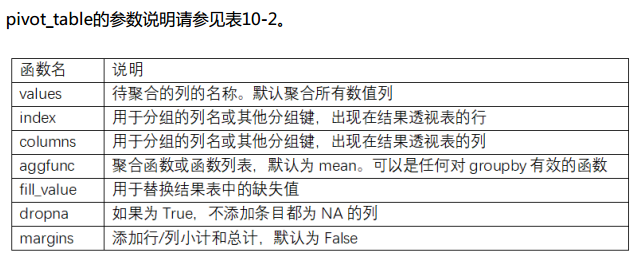

## 交叉表：crosstab

- 交叉表（cross-tabulation，简称crosstab）是一种用于计算分组频率的特殊透视表。
看下面的例子：

In [55]:
from io import StringIO
# 内存中读写str
data = """\
Sample  Nationality  Handedness
1   USA  Right-handed
2   Japan    Left-handed
3   USA  Right-handed
4   Japan    Right-handed
5   Japan    Left-handed
6   Japan    Right-handed
7   USA  Right-handed
8   USA  Left-handed
9   Japan    Right-handed
10  USA  Right-handed"""
data = pd.read_table(StringIO(data), sep='\s+')

In [56]:
data

,Sample,Nationality,Handedness
0,1,USA,Right-handed
1,2,Japan,Left-handed
2,3,USA,Right-handed
3,4,Japan,Right-handed
4,5,Japan,Left-handed
5,6,Japan,Right-handed
6,7,USA,Right-handed
7,8,USA,Left-handed
8,9,Japan,Right-handed
9,10,USA,Right-handed


In [57]:
pd.crosstab(data.Nationality,data.Handedness,margins=True)

Handedness,Left-handed,Right-handed,All
Nationality,,,
Japan,2,3,5
USA,1,4,5
All,3,7,10


- crosstab的前两个参数可以是数组或Series，或是数组列表。就像小费数据

In [60]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244